
# Example: Variational Autoencoder


$a^2$

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



import numpy as np
import argparse
import inspect
import os
import time

import matplotlib.pyplot as plt

from jax import jit, lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey
import jax

import numpyro
from numpyro import optim
import numpyro.distributions as dist
from numpyro.examples.datasets import MNIST, load_dataset
from numpyro.infer import SVI, Trace_ELBO

from types import SimpleNamespace

from numpyro.optim import Adagrad

from numpyro.contrib.einstein import RBFKernel
from mixture_guide_impl_source import MixtureGuidePredictive
from stein_impl_source import SteinVI

import vae_example

from functools import partial


/home/kenn50/miniconda3/envs/wsl-test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Temp dir in kernel
RESULTS_DIR = os.path.abspath(
    os.path.join(os.path.dirname(inspect.getfile(lambda: None)), ".results")
)
RESULTS_DIR = "./smi_results"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [3]:


def encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )


In [4]:

def decoder(hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
        stax.Sigmoid,
    )



In [5]:
def model(batch, hidden_dim=400, z_dim=None):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", decoder(hidden_dim, out_dim), (batch_dim, z_dim))
    with numpyro.plate("batch", batch_dim):
        z = numpyro.sample("z", dist.Normal(0, 1).expand([z_dim]).to_event(1))
        img_loc = decode(z)
        return numpyro.sample("obs", dist.Bernoulli(img_loc).to_event(1), obs=batch)



In [6]:


def guide(batch, hidden_dim=400, z_dim=100):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)

    encode = numpyro.module("encoder", encoder(hidden_dim, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    with numpyro.plate("batch", batch_dim):
        d = dist.Normal(z_loc, z_std).to_event(1)
        
        z = numpyro.sample("z", d)
        return z



In [7]:
def time_f(func, active = False):
    def time_func(*args, **kwargs):
        t = time.time()
        result = func(*args, **kwargs)
        if(active):
            print(f"took {time.time() - t}s to run {func.__name__}")
        return result
    return time_func


def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)


args = SimpleNamespace()
args.num_epochs = 15
args.learning_rate =5.0e-3
args.batch_size = 128
args.z_dim = 51
args.hidden_dim = 400
args.ada_step_size = 0.05

args.num_stein_particles = 10
args.num_elbo_particles = 10



encoder_nn = encoder(args.hidden_dim, args.z_dim)
decoder_nn = decoder(args.hidden_dim, 28 * 28)
adam = optim.Adam(args.learning_rate)
ada = Adagrad(args.ada_step_size)


method = SteinVI(
    model,
    guide,
    ada,
    RBFKernel(), 
    hidden_dim=args.hidden_dim, 
    z_dim=args.z_dim, 
    num_stein_particles=args.num_stein_particles, 
    num_elbo_particles=args.num_elbo_particles,
    loss_temperature=3
    )



rng_key = PRNGKey(0)
train_init, train_fetch = load_dataset(
    MNIST, batch_size=args.batch_size, split="train"
)
test_init, test_fetch = load_dataset(
    MNIST, batch_size=args.batch_size, split="test"
)
num_train, train_idx = train_init()
rng_key, rng_key_binarize, rng_key_init = random.split(rng_key, 3)
sample_batch = binarize(rng_key_binarize, train_fetch(0, train_idx)[0])
state = method.init(rng_key_init, sample_batch)

In [8]:


@jit
def epoch_train(state, rng_key, train_idx):
    def body_fn(i, val):
        loss_sum, state = val
        rng_key_binarize = random.fold_in(rng_key, i)
        batch = binarize(rng_key_binarize, train_fetch(i, train_idx)[0])
        state, loss = method.update(state, batch)
        loss_sum += loss
        return loss_sum, state

    return lax.fori_loop(0, num_train, body_fn, (0.0, state))

@partial(jit, static_argnums=(4,))
def eval_data(state, rng_key, data_idx, num_test, data_fetch):
    def body_fun(i, loss_sum):
        rng_key_binarize = random.fold_in(rng_key, i)
        batch = binarize(rng_key_binarize, data_fetch(i, data_idx)[0])
        # FIXME: does this lead to a requirement for an rng_key arg in svi_eval?
        loss = method.evaluate(state, batch) / len(batch)
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fun, 0.0)
    loss = loss / num_test
    return loss



def encode_image(img, rng_key, particle = None):
    rng_key_binarize, rng_key_particle, rng_key_z = jax.random.split(rng_key, 3)

    params = method.get_params(state)
    test_sample = binarize(rng_key_binarize, img)

    if particle == None:
        particle = jax.random.randint(rng_key_particle, 1, 0, args.num_stein_particles)
    encoder_params = jax.tree.map(lambda x: x[particle], params["encoder$params"])

    z_mean, z_var =  encoder_nn[1](
        encoder_params, test_sample.reshape([1, -1])
    )
    z = dist.Normal(z_mean, z_var).sample(rng_key_z)
    return z

def decode_image(z):
    params = method.get_params(state)
    decoder_params = params["decoder$params"]

    return decoder_nn[1](decoder_params, z).reshape([28, 28])




def reconstruct_img(epoch, rng_key, test_idx):
    img = test_fetch(0, test_idx)[0][0]
    plt.imsave(
        os.path.join(RESULTS_DIR, "original_epoch={}.png".format(epoch)),
        img,
        cmap="gray",
    )
    img_loc = decode_image(encode_image(img, rng_key))
    plt.imsave(
        os.path.join(RESULTS_DIR, "recons_epoch={}.png".format(epoch)),
        img_loc,
        cmap="gray",
    )

def sample_imgs(rng_key, num_samples):
    params = method.get_params(state)
    decoder_params = params["decoder$params"]

    for i in range(num_samples):
        rng_key, sub_key = random.split(rng_key)
        z = dist.Normal(0, 1).expand((args.z_dim,)).sample(sub_key)
        img_loc = decoder_nn[1](decoder_params, z).reshape([28, 28])
        plt.imsave(
            f"samples/sample{i}.png",
            img_loc,
            cmap="gray",
        )
        
@jit
def mse_loss(targets: jnp.ndarray, preds: jnp.ndarray):
    def single_mse(target: jnp.ndarray, pred:jnp.ndarray):
        target = target.reshape(-1)
        pred = pred.reshape(-1)
        return jnp.mean((target - pred)**2)
    return jnp.mean(jax.vmap(single_mse)(targets, preds))


def epoch_conclude_mse(rng_key, test_idx):
    imgs = test_fetch(0, test_idx)[0]
    reconstructed = jax.vmap(lambda img, key: decode_image(encode_image(img, key)))(imgs, jax.random.split(rng_key, len(imgs)))
    return mse_loss(imgs, reconstructed)


def visualize_latent_space(rng_key, test_idx):
    imgs = test_fetch(0, test_idx)[0]
    ps = args.num_stein_particles
    l = len(imgs)

    colors = np.zeros((ps, l))
    zs = np.zeros((ps, l, args.z_dim))

    for particle in range(ps):
        rng_key, sub_key = jax.random.split(rng_key)
        colors[particle, :] = particle
        zs[particle] = np.array(jax.vmap(lambda img, key: encode_image(img, key, particle))(imgs, jax.random.split(sub_key, len(imgs)))).reshape((l, args.z_dim))
        
    colors = colors.flatten()
    zs = zs.reshape((ps*l, args.z_dim))
    # Now do TSNE

    zs_scaled = StandardScaler().fit_transform(zs)
    zs_pca = PCA(n_components=50).fit_transform(zs_scaled)
    
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(zs_pca)

    # 5. Visualize
    plt.figure(figsize=(10, 7))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, cmap='viridis', s=5)
    plt.colorbar()
    plt.title("t-SNE Visualization")
    plt.show()
        




In [94]:


for i in range(args.num_epochs):
    rng_key, rng_key_train, rng_key_test, rng_key_reconstruct = random.split(
        rng_key, 4
    )
    t_start = time.time()
    num_train, train_idx = train_init()
    
    _, state = time_f(epoch_train)(state, rng_key_train, train_idx)
    rng_key, rng_key_test, rng_key_train, rng_key_reconstruct = random.split(rng_key, 4)
    num_test, test_idx = test_init()
    test_loss = time_f(eval_data)(state, rng_key_test, test_idx, num_test, test_fetch)
    train_loss = time_f(eval_data)(state, rng_key_train, train_idx, num_train, train_fetch)
    
    time_f(reconstruct_img)(i, rng_key_reconstruct, test_idx)

    rng_key, rng_key_mse = jax.random.split(rng_key)
    mse_loss_val = epoch_conclude_mse(rng_key, test_idx)
    print(
        "Epoch {}: loss = {} ({:.2f} s.), mse_loss = {}".format(
            i, train_loss, time.time() - t_start, mse_loss_val
        )
    )
rng_key, rng_key_sample = random.split(rng_key)



Epoch 0: loss = 88.19213104248047 (24.92 s.), mse_loss = 0.037271950393915176
Epoch 1: loss = 194.52664184570312 (1.49 s.), mse_loss = 0.02539699152112007
Epoch 2: loss = 236.30569458007812 (1.55 s.), mse_loss = 0.021523211151361465
Epoch 3: loss = 268.4861755371094 (1.61 s.), mse_loss = 0.017762083560228348
Epoch 4: loss = 366.0832824707031 (1.55 s.), mse_loss = 0.017814509570598602
Epoch 5: loss = 233.4092254638672 (1.58 s.), mse_loss = 0.015096807852387428
Epoch 6: loss = 308.8066711425781 (1.60 s.), mse_loss = 0.014439715072512627
Epoch 7: loss = 365.0431823730469 (1.61 s.), mse_loss = 0.012882998213171959
Epoch 8: loss = 293.06048583984375 (1.59 s.), mse_loss = 0.014086112380027771
Epoch 9: loss = 457.8837890625 (1.59 s.), mse_loss = 0.013644248247146606
Epoch 10: loss = 386.54302978515625 (1.59 s.), mse_loss = 0.01310940831899643
Epoch 11: loss = 293.78271484375 (1.58 s.), mse_loss = 0.013378150761127472
Epoch 12: loss = 256.9627685546875 (1.55 s.), mse_loss = 0.01250831410288810

In [9]:
import pickle
save = False

if (save):
    with open('state_particle1.pkl', 'wb') as file:
        pickle.dump(state, file)
else:
    with open('state.pkl', 'rb') as file:
        loaded_pickle = pickle.load(file)
    state = loaded_pickle

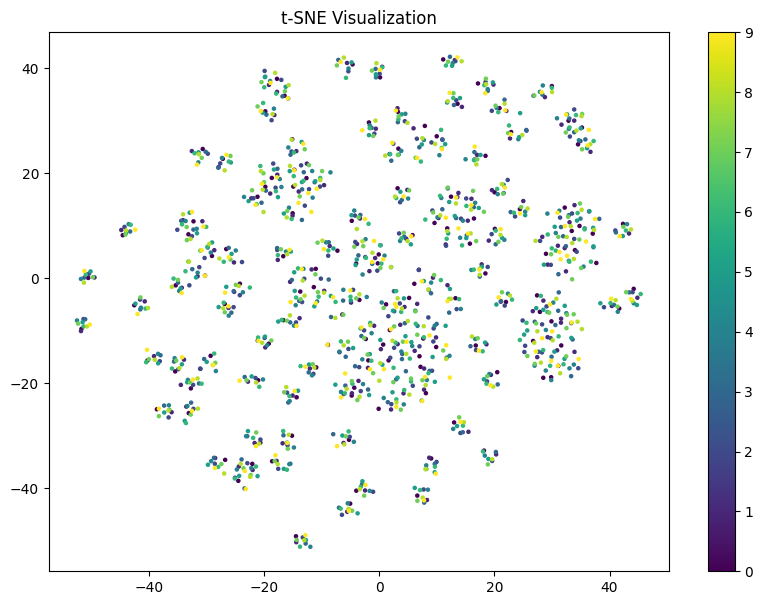

In [11]:
num_test, test_idx = test_init()
# As can be seen on this image, every single encoder is exactly the same
visualize_latent_space(rng_key, test_idx)

In [84]:
weights_layer = method.get_params(state)["encoder$params"][0][0]
#Large norm, but they still converge to the same zs. The repulsion on parameters doesnt seemt o have an effect on the resulting z
np.linalg.norm(weights_layer[0] - weights_layer[3])


np.float32(1121.0973)

In [96]:
rng_key, sub_key = jax.random.split(rng_key)
sample_imgs(sub_key,5) #Horrible results, potentially very bad hole problem.

In [23]:
vae_example.main_with_args()

Epoch 0: loss = 143.7112579345703 (14.26 s.), mse_loss = 0.03674609214067459
Epoch 1: loss = 121.81253814697266 (0.46 s.), mse_loss = 0.02517949976027012
Epoch 2: loss = 115.04705047607422 (0.12 s.), mse_loss = 0.02047920599579811
Epoch 3: loss = 111.99622344970703 (0.12 s.), mse_loss = 0.019579891115427017
Epoch 4: loss = 110.09611511230469 (0.12 s.), mse_loss = 0.018653705716133118
Epoch 5: loss = 109.02849578857422 (0.12 s.), mse_loss = 0.01928989216685295
Epoch 6: loss = 107.8291015625 (0.12 s.), mse_loss = 0.017941094934940338
Epoch 7: loss = 107.57439422607422 (0.12 s.), mse_loss = 0.017174717038869858
Epoch 8: loss = 107.30595397949219 (0.12 s.), mse_loss = 0.01743471622467041
Epoch 9: loss = 106.43675994873047 (0.12 s.), mse_loss = 0.018033649772405624
Epoch 10: loss = 106.08879089355469 (0.12 s.), mse_loss = 0.018783163279294968
Epoch 11: loss = 105.81175994873047 (0.12 s.), mse_loss = 0.017368517816066742
Epoch 12: loss = 104.96485900878906 (0.12 s.), mse_loss = 0.01674378477

C

In [21]:
TO_DELETE=RESULTS_DIR

# List all files in the directory
for filename in os.listdir(TO_DELETE):
    file_path = os.path.join(TO_DELETE, filename)
    
    # Check if it is a file (not a subdirectory)
    if os.path.isfile(file_path):
        os.remove(file_path)  # Remove the file
        print(f"Deleted file: {filename}")
os.rmdir(TO_DELETE, )
os.makedirs(TO_DELETE, exist_ok=True)
